In [13]:
import sys
import os
import glob
from time import process_time

import pystare as ps

import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 10000
# mpl.rcParams['agg.path.chunksize'] = 10000000
# mpl.use("Agg")

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import geopandas

from netCDF4 import Dataset
from pyhdf.SD import SD, SDC

%matplotlib inline

In [2]:
def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr():
    sys.stderr.close()
    with open('stderr.out') as f:
        count = sum(1 for _ in f)
    if count > 0:
        print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

# Some helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax,plot_options=None):
        self.fig = figax[0]
        self.ax  = figax[1]
        self.plot_options = plot_options
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options=None
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ,dbg=False
        ):


    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        if dbg:
            print('lons: ',lons)
            print('lats: ',lats)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        # print('plot type triang: ',type(siv_triang))

    if plot_options is None:
        if spatial_index_values is not None:
            plot_options = {
                'projection':ccrs.PlateCarree(
                    central_longitude=((0.5*((numpy.amin(180+lons)+numpy.amax(180+lons)) % 360.0))-180)
                                              # ,central_latitude=0.5*(numpy.amin(lats)+numpy.amax(lats))
                                                )
            ,'transform':ccrs.Geodetic()}
            print('hp-po central_longitude: '
              ,((0.5*((numpy.amin(180+lons)+numpy.amax(180+lons)) % 360.0))-180)
             )
        else:
            plot_options = {'projection':ccrs.PlateCarree()
                           ,'transform':ccrs.Geodetic()}

        
    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options),plot_options=plot_options)
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax  
        
    if spatial_index_values is not None: 
        divert_stderr()
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
        restore_stderr()
    
    if show:
        plt.show()
        
    if dbg:
        return figax,lons,lat,intmat
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [51]:
class load05_stare(object):
    def __init__(self,file_name):
        self.file_name   = file_name
        self.ds          = Dataset(file_name)
        self.lat0        = self.ds['Latitude_5km'][:,:].flatten()
        self.lon0        = self.ds['Longitude_5km'][:,:].flatten()
        self.spatial_id0 = self.ds['STARE_index_5km'][:,:].flatten().astype(numpy.int64)
    def shape(self,key='Latitude_5km'):
        return self.ds[key].shape
    def cover(self,key='STARE_cover_5km'):
        return self.ds[key][:].astype(numpy.int64)
    def close(self):
        self.ds.close()

In [5]:
mod05_filelist = sorted(glob.glob('/Users/mrilee/git/STAREmaster-build/test/data/*.nc'))

In [6]:
mod05_filelist

['/Users/mrilee/git/STAREmaster-build/test/data/MOD05_L2.A2005349.2125.061.2017294065400_stare.nc',
 '/Users/mrilee/git/STAREmaster-build/test/data/MOD09GA.A2020009.h00v08.006.2020011025435_stare.nc']

In [10]:
obj = load05_stare(mod05_filelist[0])

hp-po central_longitude:  -159.80102496664767


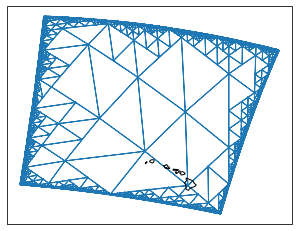

In [17]:
hello_plot(obj.cover())
plt.show()

In [27]:
!ls -l `which createSidecarFile`; ls -l /Users/mrilee/opt/local/bin/createSidecarFile; ls -l /Users/mrilee/git/STAREmaster-build/src/createSidecarFile

lrwxr-xr-x  1 mrilee  wheel  45 Jul 17 16:49 /Users/mrilee/opt/anaconda3/envs/develop/bin/createSidecarFile -> /Users/mrilee/opt/local/bin/createSidecarFile
lrwxr-xr-x  1 mrilee  staff  57 Sep  8 22:17 /Users/mrilee/opt/local/bin/createSidecarFile -> /Users/mrilee/git/STAREmaster-build/src/createSidecarFile
-rwxr-xr-x  1 mrilee  staff  1359892 Oct 15 18:56 /Users/mrilee/git/STAREmaster-build/src/createSidecarFile


In [28]:
# %%timeit
!createSidecarFile -v extras/MOD05_L2.A2005349.2125.061.2017294065400.hdf-1

GeoFile constructor
ModisL2GeoFile constructor
Reading HDF4 file extras/MOD05_L2.A2005349.2125.061.2017294065400.hdf-1 with build level 5
nswath 1 mod05
calculating perimeter
perimeter size = 140, pk = 1207
cover size = 7230
ndims 6 Cell_Along_Swath_1km,Cell_Across_Swath_1km,Cell_Along_Swath_5km,Cell_Across_Swath_5km,QA_Bytes_IR,QA_Bytes_NIR
dim Cell_Along_Swath_1km dimsize 2030
dim Cell_Across_Swath_1km dimsize 1354
dim Cell_Along_Swath_5km dimsize 406
dim Cell_Across_Swath_5km dimsize 270
dim QA_Bytes_IR dimsize 5
dim QA_Bytes_NIR dimsize 1
Cell_Along_Swath_1km
Cell_Across_Swath_1km
Cell_Along_Swath_5km
Cell_Across_Swath_5km
QA_Bytes_IR
QA_Bytes_NIR
ngeofields 2 Latitude,Longitude
ndatafields 11 Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Cloud_Mask_QA,Water_Vapor_Near_Infrared,Water_Vapor_Correction_Factors,Water_Vapor_Infrared,Quality_Assurance_Near_Infrared,Quality_Assurance_Infrared
nmaps 2 Cell_Across_Swath_5km/Cell_Across_Swath_1km,Cell_Along_Swath_5

In [56]:
%timeit -n 1 
!OMP_NUM_THREADS=8 createSidecarFile -c 8 -s 20 -v extras/MOD05_L2.A2005349.2125.061.2017294065400.hdf-1

GeoFile constructor
ModisL2GeoFile constructor
Reading HDF4 file extras/MOD05_L2.A2005349.2125.061.2017294065400.hdf-1 with build level 5
nswath 1 mod05
perimeter_stride 20
calculating perimeter
perimeter size = 74, pk = 1273
cover_level = 8
cover size = 859
ndims 6 Cell_Along_Swath_1km,Cell_Across_Swath_1km,Cell_Along_Swath_5km,Cell_Across_Swath_5km,QA_Bytes_IR,QA_Bytes_NIR
dim Cell_Along_Swath_1km dimsize 2030
dim Cell_Across_Swath_1km dimsize 1354
dim Cell_Along_Swath_5km dimsize 406
dim Cell_Across_Swath_5km dimsize 270
dim QA_Bytes_IR dimsize 5
dim QA_Bytes_NIR dimsize 1
Cell_Along_Swath_1km
Cell_Across_Swath_1km
Cell_Along_Swath_5km
Cell_Across_Swath_5km
QA_Bytes_IR
QA_Bytes_NIR
ngeofields 2 Latitude,Longitude
ndatafields 11 Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Cloud_Mask_QA,Water_Vapor_Near_Infrared,Water_Vapor_Correction_Factors,Water_Vapor_Infrared,Quality_Assurance_Near_Infrared,Quality_Assurance_Infrared
nmaps 2 Cell_Across_Swath_5km/Cell_A

In [57]:
mod05_filelist = sorted(glob.glob('extras/*.nc'))


In [58]:
mod05_filelist

['extras/MOD05_L2.A2005349.2125.061.2017294065400_stare.nc',
 'extras/goes10.2005.349.213015.BAND_05.nc']

hp-po central_longitude:  -159.8744142713986


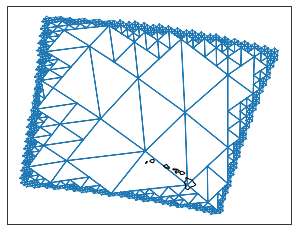

In [59]:
obj = load05_stare(mod05_filelist[0])
hello_plot(obj.cover())
plt.show()
obj.close()